In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.key(0)

In [2]:
# 预热：计算二阶导数

def hessian(f):
  return jax.jacfwd(jax.grad(f))

def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

# Higher-order optimization

## Stopping gradients

In [3]:
# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

# An example transition.
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

In [4]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((target - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

Array([-1.2,  1.2, -1.2], dtype=float32)

In [5]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((jax.lax.stop_gradient(target) - v_tm1) ** 2)
# This is the most important line in the code.

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

print(delta_theta)

# 手动写代码验证上面的结果
grad_fn = jax.grad(value_fn)
(r_t+value_fn(theta, s_t)-value_fn(theta, s_tm1))*grad_fn(theta, s_tm1)

[ 1.2  2.4 -1.2]


Array([ 1.2,  2.4, -1.2], dtype=float32)

## Straight-through estimator using stop_gradient

In [6]:
def f(x):
  return jnp.round(x)  # non-differentiable

def straight_through_f(x):
  # Create an exactly-zero expression with Sterbenz lemma that has
  # an exactly-one gradient.
  zero = x - jax.lax.stop_gradient(x)
  return zero + jax.lax.stop_gradient(f(x))

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

# 前向传播就是函数求值
# 反向传播就是函数求导（用链式法则）

f(x):  3.0
straight_through_f(x): 3.0
grad(f)(x): 0.0
grad(straight_through_f)(x): 1.0


## Per-example gradients

In [7]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

# Test it:
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

Array([[ 1.2,  2.4, -1.2],
       [ 1.2,  2.4, -1.2]], dtype=float32)

## Hessian-vector products with jax.grad-of-jax.grad

In [8]:
def hvp(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

def gprod(f, x, v):
    return grad(f)(x) @ v

# 或者不用 lambda 用下面的这种写法？
def hvp2(f, x, v):
    return grad(gprod, argnums=1)(x) @ v

In [9]:
# jax.grad 是什么形状的？

import jax.numpy as jnp
from jax import grad

# 定义目标函数
def f(x):
    return jnp.sum(x ** 2)  # 简单的二次函数

# 输入变量
x = jnp.array([[1.0, 2.0], [3.0, 4.0]])

# 计算梯度
grad_f = grad(f)(x)

print("输入变量 x 的形状:", x.shape)
print("梯度向量 grad_f 的形状:", grad_f.shape)

输入变量 x 的形状: (2, 2)
梯度向量 grad_f 的形状: (2, 2)


In [10]:
# 补课：点积和矩阵乘法

import jax.numpy as jnp

# 一维向量点积（标量）
a = jnp.array([1, 2, 3])
b = jnp.array([4, 5, 6])
print("一维向量点积（标量）")
print(jnp.dot(a, b))   # 32
print(a @ b)    # 32
print(jnp.matmul(a, b))  # [4 10 18]

print(jnp.inner(a, b))  # 32
print(jnp.vdot(a, b))   # 32

# 二维矩阵乘法
A = jnp.array([[1, 2], [3, 4]])
B = jnp.array([[5, 6], [7, 8]])
print(jnp.dot(A, B))   # works
print(A @ B)           # works
print(jnp.matmul(A, B))   # works

# 更高维度建议用 jnp.matmul 或 @
# 不推荐用 jnp.dot

# jnp.tensordot 这个比较复杂，有待进一步学习

一维向量点积（标量）
32
32
32
32
32
[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[19 22]
 [43 50]]


## Jacobians and Hessians using jax.jacfwd and jax.jacrev

In [11]:
from jax import jacfwd, jacrev

# Define a sigmoid function.
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

J = jacfwd(f)(W)
print("jacfwd result, with shape", J.shape)
print(J)

J = jacrev(f)(W)
print("jacrev result, with shape", J.shape)
print(J)

jacfwd result, with shape (4, 3)
[[ 0.05069415  0.1091874   0.07506633]
 [ 0.14170025 -0.17390487  0.02415345]
 [ 0.12579198  0.01451446 -0.31447992]
 [ 0.00574409 -0.0193281   0.01078958]]
jacrev result, with shape (4, 3)
[[ 0.05069415  0.10918739  0.07506634]
 [ 0.14170025 -0.17390487  0.02415345]
 [ 0.12579198  0.01451446 -0.31447995]
 [ 0.00574409 -0.0193281   0.01078958]]


These two functions compute the same values (up to machine numerics), but differ in their implementation: jax.jacfwd() uses forward-mode automatic differentiation, which is more efficient for “tall” Jacobian matrices (more outputs than inputs), while jax.jacrev() uses reverse-mode, which is more efficient for “wide” Jacobian matrices (more inputs than outputs). For matrices that are near-square, jax.jacfwd() probably has an edge over jax.jacrev().

In [12]:
def predict_dict(params, inputs):
    return predict(params['W'], params['b'], inputs)

J_dict_fwd = jacfwd(predict_dict)({'W': W, 'b': b}, inputs)
J_dict_rev = jacrev(predict_dict)({'W': W, 'b': b}, inputs)

for k, v in J_dict_fwd.items():
    print(f"Jacobian from {k} to logits is")
    print(v)
for k, v in J_dict_rev.items():
    print(f"Jacobian from {k} to logits is")
    print(v)

Jacobian from W to logits is
[[ 0.05069415  0.1091874   0.07506633]
 [ 0.14170025 -0.17390487  0.02415345]
 [ 0.12579198  0.01451446 -0.31447992]
 [ 0.00574409 -0.0193281   0.01078958]]
Jacobian from b to logits is
[0.09748875 0.16102302 0.24190766 0.00776229]
Jacobian from W to logits is
[[ 0.05069415  0.10918739  0.07506634]
 [ 0.14170025 -0.17390487  0.02415345]
 [ 0.12579198  0.01451446 -0.31447995]
 [ 0.00574409 -0.0193281   0.01078958]]
Jacobian from b to logits is
[0.09748875 0.16102302 0.24190766 0.00776229]


# How it’s made: Two foundational autodiff functions

## Jacobian-Vector products (JVPs, a.k.a. forward-mode autodiff)

In [13]:
from jax import jvp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

key, subkey = random.split(key)
v = random.normal(subkey, W.shape)

# Push forward the vector `v` along `f` evaluated at `W`
y, u = jvp(f, (W,), (v,))
print("使用 jvp 计算的结果")
print("y:", y)
print("u:", u)

print("下面是手动验证的代码")
print(f"y: {f(W)}\nu: {jax.jacobian(f)(W)@v}")

# 教程中的 “FLOP” 是 Floating Point Operation（浮点运算） 的缩写，是衡量计算量的一个基本单位。

使用 jvp 计算的结果
y: [0.10947311 0.79829013 0.41004258 0.99217653]
u: [-0.19177328 -0.13542867  0.18863559 -0.01155983]
下面是手动验证的代码
y: [0.10947311 0.79829013 0.41004258 0.99217653]
u: [-0.19177328 -0.13542865  0.18863557 -0.01155983]


## Vector-Jacobian products (VJPs, a.k.a. reverse-mode autodiff)

In [14]:
from jax import vjp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

y, vjp_fun = vjp(f, W)

key, subkey = random.split(key)
#u = random.normal(subkey, y.shape)
u = jnp.array([1., 0., 0., 0.])  # 只取第一个元素的梯度

# Pull back the covector `u` along `f` evaluated at `W`
v = vjp_fun(u)

u, v

(Array([1., 0., 0., 0.], dtype=float32),
 (Array([0.05069415, 0.10918739, 0.07506634], dtype=float32),))

## Vector-valued gradients with VJPs

In [15]:
def vgrad(f, x):
  y, vjp_fn = vjp(f, x)
  return vjp_fn(jnp.ones(y.shape))[0]

x = jnp.array([[1.0, 2.0], [3.0, 4.0]])

print(vgrad(lambda x: 3*x**2, x))

[[ 6. 12.]
 [18. 24.]]


In [16]:
# 或者也可以手动实现

f = lambda x:3*x**2
vdf = jax.vmap(grad(f))
vdf = vdf(x.reshape(-1))
print(vdf, "但是这个形状变了！")

varf = lambda x: jnp.sum(3 * x ** 2)
print(varf(x), "这个函数变了！")
vardf = jax.grad(varf)
print(vardf(x))  # 输出 shape 为 (2,2)，结果是全 6

[ 6. 12. 18. 24.] 但是这个形状变了！
90.0 这个函数变了！
[[ 6. 12.]
 [18. 24.]]


## Hessian-vector products using both forward- and reverse-mode

In [17]:
def f(X):
  return jnp.sum(jnp.tanh(X)**2)

key, subkey1, subkey2 = random.split(key, 3)
X = random.normal(subkey1, (30, 40))
V = random.normal(subkey2, (30, 40))

# forward-over-reverse
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]

# Reverse-over-forward
def hvp_revfwd(f, primals, tangents):
  g = lambda primals: jvp(f, primals, tangents)[1]
  return grad(g)(primals)

# Reverse-over-reverse, only works for single arguments
def hvp_revrev(f, primals, tangents):
  x, = primals
  v, = tangents
  return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

print("Forward over reverse")
%timeit -n10 -r3 hvp(f, (X,), (V,))
print("Reverse over forward")
%timeit -n10 -r3 hvp_revfwd(f, (X,), (V,))
print("Reverse over reverse")
%timeit -n10 -r3 hvp_revrev(f, (X,), (V,))
print("Naive full Hessian materialization")
%timeit -n10 -r3 jnp.tensordot(hessian(f)(X), V, 2)

Forward over reverse
The slowest run took 13.59 times longer than the fastest. This could mean that an intermediate result is being cached.
13.1 ms ± 14.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Reverse over forward
The slowest run took 7.46 times longer than the fastest. This could mean that an intermediate result is being cached.
11.2 ms ± 10.6 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Reverse over reverse
The slowest run took 6.44 times longer than the fastest. This could mean that an intermediate result is being cached.
16.6 ms ± 13.8 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
Naive full Hessian materialization
The slowest run took 4.46 times longer than the fastest. This could mean that an intermediate result is being cached.
30.6 ms ± 22.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


# Composing VJPs, JVPs, and jax.vmap

## Jacobian-Matrix and Matrix-Jacobian products

In [18]:
# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

# Pull back the covectors `m_i` along `f`, evaluated at `W`, for all `i`.
# First, use a list comprehension to loop over rows in the matrix M.
def loop_mjp(f, x, M):
    y, vjp_fun = vjp(f, x)
    return jnp.vstack([vjp_fun(mi) for mi in M])

# Now, use vmap to build a computation that does a single fast matrix-matrix
# multiply, rather than an outer loop over vector-matrix multiplies.
def vmap_mjp(f, x, M):
    y, vjp_fun = vjp(f, x)
    outs, = vmap(vjp_fun)(M)
    return outs

def vmap_mjp2(f, x, M):
    y, jvp_fun = vmap(jvp, in_axes=(None, None, 0))(f, (x,), (M,))
    outs = jvp_fun
    return outs

key = random.key(0)
num_covecs = 128
U = random.normal(key, (num_covecs,) + y.shape)
V = random.normal(key, (num_covecs,) + W.shape)


loop_vs = loop_mjp(f, W, M=U)
print('Non-vmapped Matrix-Jacobian product')
%timeit -n10 -r3 loop_mjp(f, W, M=U)

print('\nVmapped Matrix-Jacobian product, reverse-mode')
vmap_vs = vmap_mjp(f, W, M=U)
%timeit -n10 -r3 vmap_mjp(f, W, M=U)

print('\nVmapped Matrix-Jacobian product forward-mode')
vmap_vs2 = vmap_mjp2(f, W, M=V)
%timeit -n10 -r3 vmap_mjp2(f, W, M=V)

# assert jnp.allclose(loop_vs, vmap_vs), 'Vmap and non-vmapped Matrix-Jacobian Products should be identical'

C:\Users\weiz828\AppData\Local\Temp\ipykernel_17548\2257824564.py:8: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'tuple'> at position 0. In a future JAX release this will be an error.
  return jnp.vstack([vjp_fun(mi) for mi in M])


Non-vmapped Matrix-Jacobian product
66.5 ms ± 4.6 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)

Vmapped Matrix-Jacobian product, reverse-mode
2.61 ms ± 36.8 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)

Vmapped Matrix-Jacobian product forward-mode
1.73 ms ± 53.4 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


## The implementation of jax.jacfwd and jax.jacrev

In [19]:
from jax import jacrev as builtin_jacrev

def our_jacrev(f):
    def jacfun(x):
        y, vjp_fun = vjp(f, x)
        # Use vmap to do a matrix-Jacobian product.
        # Here, the matrix is the Euclidean basis, so we get all
        # entries in the Jacobian at once.
        J, = vmap(vjp_fun, in_axes=0)(jnp.eye(len(y)))
        return J
    return jacfun

assert jnp.allclose(builtin_jacrev(f)(W), our_jacrev(f)(W)), 'Incorrect reverse-mode Jacobian results!'

In [20]:
from jax import jacfwd as builtin_jacfwd

def our_jacfwd(f):
    def jacfun(x):
        _jvp = lambda s: jvp(f, (x,), (s,))[1]
        Jt = vmap(_jvp, in_axes=1)(jnp.eye(len(x)))
        return jnp.transpose(Jt)
    return jacfun

assert jnp.allclose(builtin_jacfwd(f)(W), our_jacfwd(f)(W)), 'Incorrect forward-mode Jacobian results!'

In [21]:
# 补课：闭包与函数嵌套调用

def func1(a):
    def func2(b):
        return a + b
    return func2

func1(1)(2)  # 3

3

In [22]:
def f(x):
    try:
        if x < 3.:
            return 2 * x ** 3
        else:
            raise ValueError
    except ValueError:
        return jnp.pi * x

y, f_vjp = vjp(f, -1.) # This is OK with JIT, since the second parameter is already given.
print(jit(f_vjp)(1.))

(Array(6., dtype=float32, weak_type=True),)


# Custom derivative rules for JAX-transformable Python functions

✅ 何时用 @custom_jvp？
- 函数里包含 非平滑或不可导操作（如 round, clip, quantize 等）；
- 或者你知道函数的导数形式比自动推导更稳定/高效/符合你的预期。

In [49]:
from jax import custom_jvp
import jax.numpy as jnp
from jax import grad

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

@f.defjvp
def f_jvp(primals, tangents):
  #print("primals:", primals, type(primals))
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out

print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

2.7278922
primals: (2.0, 3.0) <class 'tuple'>
2.7278922
-1.2484405
primals: (2.0, 3.0) <class 'tuple'>
-1.2484405


In [24]:
# Equivalent alternative using the `defjvps` convenience wrapper

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

f.defjvps(lambda x_dot, primal_out, x, y: jnp.cos(x) * x_dot * y,
          lambda y_dot, primal_out, x, y: jnp.sin(x) * y_dot)
# 这里 x_dot 是切向量的分量，y_dot 是切向量的分量
# primal_out 是原函数的输出
# x, y 是原函数的输入

# 这个 defjvps 的用法是：
# “如果你要对 f(x, y) 在 x 上求导，就用第一个函数；
# 如果你要在 y 上求导，就用第二个函数。”


print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

2.7278922
2.7278922
-1.2484405
-1.2484405


In [25]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
# Returns primal output and residuals to be used in backward pass by `f_bwd`.
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)
# residual 是可以在反向传播中使用的中间变量
# residual 可以是自行决定的

def f_bwd(res, g):
  cos_x, sin_x, y = res # Gets residuals computed in `f_fwd`
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)

print(grad(f)(2., 3.))

-1.2484405


## Example problems

In [27]:
# 重新定义求导规则解决数值稳定性的问题

def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

@log1pexp.defjvp
def log1pexp_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = log1pexp(x)
  ans_dot = (1 - 1/(1 + jnp.exp(x))) * x_dot
  return ans, ans_dot

print(grad(log1pexp)(100.))

1.0


In [31]:
# 或者换一种写法
@custom_jvp
def log1pexp(x):
  return jnp.log(1. + jnp.exp(x))

log1pexp.defjvps(lambda t, ans, x: (1 - 1/(1 + jnp.exp(x))) * t)
# t 是切向量的分量 只有一个分量
# ans 是原函数的输出
# x 是原函数的输入

jvp(log1pexp, (8.,), (1.,))

(Array(8.000336, dtype=float32, weak_type=True),
 Array(0.99966466, dtype=float32, weak_type=True))

In [34]:
# 重新定义求导规则解决函数奇点

@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  ans_dot = ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * x_dot
  return ans, ans_dot

print(grad(f)(0.))

1.0


In [33]:
# 或者换一种写法
@custom_jvp
def f(x):
  return x / (1 + jnp.sqrt(x))

f.defjvps(lambda t, ans, x: ((jnp.sqrt(x) + 2) / (2 * (jnp.sqrt(x) + 1)**2)) * t)

print(grad(f)(0.))

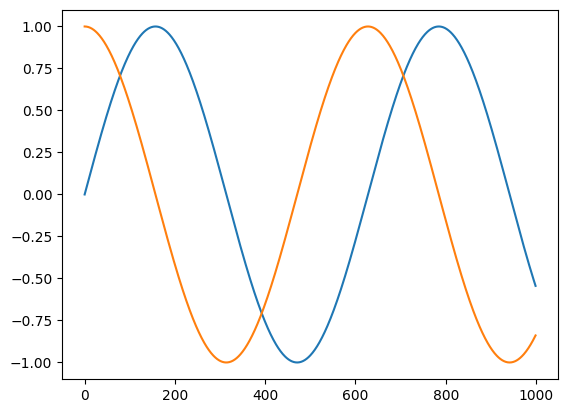

In [36]:
from functools import partial

@custom_vjp
def clip_gradient(lo, hi, x):
  return x  # identity function

def clip_gradient_fwd(lo, hi, x):
  return x, (lo, hi)  # save bounds as residuals

def clip_gradient_bwd(res, g):
  lo, hi = res
  return (None, None, jnp.clip(g, lo, hi))  # use None to indicate zero cotangents for lo and hi
# None 的意思是对 lo 和 hi 没有导数

clip_gradient.defvjp(clip_gradient_fwd, clip_gradient_bwd)

import matplotlib.pyplot as plt

t = jnp.linspace(0, 10, 1000)

plt.plot(jnp.sin(t))
plt.plot(vmap(grad(jnp.sin))(t))

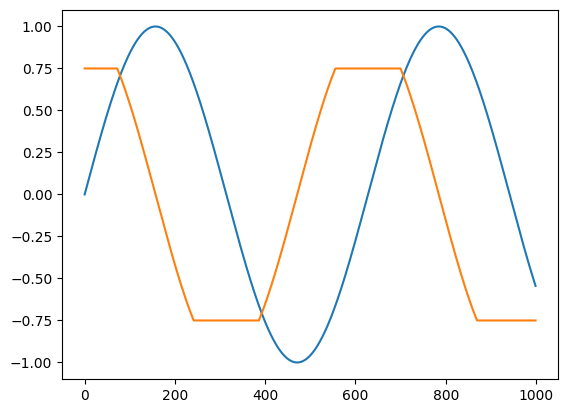

In [40]:
def clip_sin(x):
  x = clip_gradient(-0.75, 0.75, x)
  return jnp.sin(x)
# 这是一个复合函数其实，所以 g 参数就是 cosx

plt.plot(clip_sin(t))
plt.plot(vmap(grad(clip_sin))(t))

## Basic usage of jax.custom_jvp and jax.custom_vjp APIs

摘抄：

Even though we defined only a JVP rule and no VJP rule, we can use both forward- and reverse-mode differentiation on f. JAX will automatically transpose the linear computation on tangent values from our custom JVP rule, computing the VJP as efficiently as if we had written the rule by hand.

jax.custom_jvp() suffices for controlling both forward- and, via JAX’s automatic transposition, reverse-mode differentiation behavior.

As with jax.custom_jvp(), the custom VJP rule composed of f_fwd and f_bwd is not invoked if differentiation is not applied.

Forward-mode autodiff cannot be used on the jax.custom_vjp() function and will raise an error:

In [47]:
# You can use Python control flow with jax.custom_jvp():
# But we cannot use JIT with the following function:

@custom_jvp
def f(x):
  if x > 0:
    return jnp.sin(x)
  else:
    return jnp.cos(x)

@f.defjvp
def f_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = f(x)
  if x > 0:
    return ans, 2 * x_dot
  else:
    return ans, 3 * x_dot


## More features and details

### Working with list / tuple / dict containers (and other pytrees)

In [88]:
from collections import namedtuple
Point = namedtuple("Point", ["x", "y"])

@custom_jvp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

@f.defjvp
def f_jvp(primals, tangents):
  pt, = primals # 这儿的逗号不能省略
  pt_dot, =  tangents
  ans = f(pt)
  ans_dot = {'a': 2 * pt.x * pt_dot.x,
             'b': (jnp.cos(pt.x) * pt_dot.x, -jnp.sin(pt.y) * pt_dot.y)}
  return ans, ans_dot

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]

pt = Point(1., 2.)
#print(f(pt))
print(grad(fun)(pt))

Point(x=Array(2.5403023, dtype=float32, weak_type=True), y=Array(0., dtype=float32, weak_type=True))


In [92]:
@custom_vjp
def f(pt):
  x, y = pt.x, pt.y
  return {'a': x ** 2,
          'b': (jnp.sin(x), jnp.cos(y))}

def f_fwd(pt):
  return f(pt), pt

def f_bwd(pt, g):
  a_bar, (b0_bar, b1_bar) = g['a'], g['b']
  x_bar = 2 * pt.x * a_bar + jnp.cos(pt.x) * b0_bar
  y_bar = -jnp.sin(pt.y) * b1_bar
  return (Point(x_bar, y_bar),)

f.defvjp(f_fwd, f_bwd)

def fun(pt):
  dct = f(pt)
  return dct['a'] + dct['b'][0]

pt = Point(1., 2.)
#print(f(pt))
print(grad(fun)(pt))

Point(x=Array(2.5403023, dtype=float32, weak_type=True), y=Array(-0., dtype=float32, weak_type=True))


### Handling non-differentiable arguments

In [96]:
from functools import partial

@partial(custom_jvp, nondiff_argnums=(0,)) #不加这个会报错 AttributeError: 'function' object has no attribute 'defjvp'
def app(f, x):
  return f(x)

@app.defjvp
def app_jvp(f, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(x), 2. * x_dot


print(app(lambda x: x ** 3, 3.))
print(grad(app, 1)(lambda x: x ** 3, 3.))

27.0
2.0


Notice the gotcha here: no matter where in the argument list these parameters appear, they’re placed at the start of the signature of the corresponding JVP rule. Here’s another example:

In [97]:
@partial(custom_jvp, nondiff_argnums=(0, 2))
def app2(f, x, g):
  return f(g((x)))

@app2.defjvp
def app2_jvp(f, g, primals, tangents):
  x, = primals
  x_dot, = tangents
  return f(g(x)), 3. * x_dot

print(app2(lambda x: x ** 3, 3., lambda y: 5 * y))
print(grad(app2, 1)(lambda x: x ** 3, 3., lambda y: 5 * y))

3375.0
3.0


In [100]:
@partial(custom_vjp, nondiff_argnums=(0,))
def app(f, x):
  return f(x)

def app_fwd(f, x):
  return f(x), x

def app_bwd(f, x, g):
  return (5 * g,)

app.defvjp(app_fwd, app_bwd)

print(app(lambda x: x ** 2, 4.))
print(grad(app, 1)(lambda x: x ** 2, 4.))

16.0
5.0


You don’t need to use nondiff_argnums with array-valued arguments, such as, for example, ones with the integer dtype. Instead, nondiff_argnums should only be used for argument values that don’t correspond to JAX types (essentially don’t correspond to array types), like Python callables or strings. If JAX detects that an argument indicated by nondiff_argnums contains a JAX Tracer, then an error is raised. The clip_gradient function above is a good example of not using nondiff_argnums for integer-dtype array arguments.

In [103]:
# 我试过了 把上面代码的第一行改成下面这样就会报错
# @partial(custom_vjp, nondiff_argnums=(0,1))